In [1]:
# import lib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
# define custom model class with MC Dropout
class MCDropoutModel(keras.Model):
    def __init__(self):
        super(MCDropoutModel, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu')
        self.pool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(64, 3, activation='relu')
        self.pool2 = layers.MaxPooling2D()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.5)
        self.out = layers.Dense(10, activation='softmax')

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        return self.out(x)

In [4]:
# compile and train model with dropout
mc_model = MCDropoutModel()
mc_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

history_mc = mc_model.fit(x_train, y_train,
                          validation_split=0.2,
                          epochs=10, batch_size=64, verbose=0)

In [5]:
# standard test-time accuracy
test_loss_std, test_acc_std = mc_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy (Dropout OFF): {test_acc_std:.4f}")

# montecarlo dropout inference
def mc_predict(model, x, num_samples=20):
    preds = np.array([model(x, training=True).numpy() for _ in range(num_samples)])
    return np.mean(preds, axis=0)

mc_preds = mc_predict(mc_model, x_test, num_samples=20)
mc_labels = np.argmax(mc_preds, axis=-1).reshape(-1)

mc_accuracy = np.mean(mc_labels == y_test.flatten())
print(f"Monte Carlo Dropout Test Accuracy (avg over 20 passes): {mc_accuracy:.4f}")

Test Accuracy (Dropout OFF): 0.6946
Monte Carlo Dropout Test Accuracy (avg over 20 passes): 0.6936


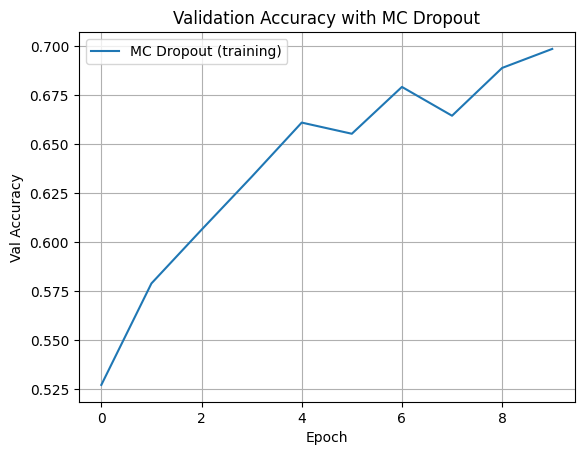

In [6]:
# plot validation accuracy
plt.plot(history_mc.history['val_accuracy'], label='MC Dropout (training)')
plt.title("Validation Accuracy with MC Dropout")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.grid(True)
plt.legend()
plt.show()